#### Core & Data Libraries

In [1]:
# ============================== Core & Data Libraries ==============================
import os                                   # File and directory operations
import pickle                               # Object serialization
import numpy as np                          # Numerical computations
import pandas as pd                         # Data manipulation and analysis

# ============================== Visualization Libraries ============================
import matplotlib.pyplot as plt              # Static plots and figures
from matplotlib.ticker import MultipleLocator # Axis tick control
from matplotlib.lines import Line2D          # Custom legend elements
import seaborn as sns                       # Statistical data visualization

# ============================== Machine Learning & Stats ===========================
from sklearn.mixture import GaussianMixture                   # Gaussian mixture models
from sklearn.metrics import mean_squared_error, r2_score      # Model evaluation metrics

from scipy.optimize import curve_fit                # Curve fitting, optimization
from scipy.stats import kstest, norm, t, skewnorm, cauchy     # Specific probability distributions
from scipy.interpolate import interp1d                        # 1D interpolation

import statsmodels.api as sm                                  # Advanced statistical modeling
import statsmodels.formula.api as smf                         # Formula-based regression

#### Load OOF Residuals

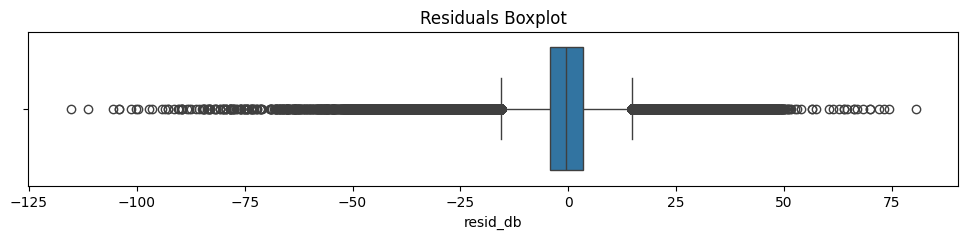

In [2]:
# pick your residuals CSV (alias shown; change if needed)
RESID_PATH = "../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__POLY2__BEST__oof.csv"

df_res = pd.read_csv(RESID_PATH)
res_col = next(c for c in ["resid_db", "residuals", "resid", "error"] if c in df_res.columns)
residuals = df_res[res_col].astype(float)  # kept as Series so `.values` works later
n = residuals.size
probabilities = (np.arange(1, n + 1) - 0.5) / n  # Standard probability calculation

# Inspect Residuals for Outliers
plt.figure(figsize=(12, 2))
sns.boxplot(x=residuals)
plt.title('Residuals Boxplot')
plt.show()


#### Fit Distributions

In [3]:
# === Fit Distributions ===

# 1. Normal Distribution
normal_params = norm.fit(residuals)
loc_norm, scale_norm = normal_params
normal_dist = norm(loc=loc_norm, scale=scale_norm)

# 2. Skew-Normal Distribution
skew_params = skewnorm.fit(residuals)
shape_sn, loc_sn, scale_sn = skew_params
skew_dist = skewnorm(shape_sn, loc=loc_sn, scale=scale_sn)

# 3. Gaussian Mixture Model (Automated Model Selection 1 and 2)
residuals_array = residuals.values.reshape(-1, 1)
lowest_bic = np.inf
bic_scores = []
# up to 5 components
n_components_range = range(1, 6)
best_gmm = None

for n_components in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n_components, random_state=42).fit(residuals_array)
    bic_value = gmm_tmp.bic(residuals_array)
    bic_scores.append(bic_value)
    if bic_value < lowest_bic:
        lowest_bic = bic_value
        best_gmm = gmm_tmp

gmm = best_gmm  # Use the best GMM selected based on the lowest BIC
print(f"\nSelected GMM with {gmm.n_components} components based on lowest BIC: {lowest_bic}")

# 4. Cauchy Distribution
cauchy_params = cauchy.fit(residuals)
cauchy_dist = cauchy(*cauchy_params)

# 5. t-Distribution
t_params = t.fit(residuals)
df_t, loc_t, scale_t = t_params
t_dist = t(df=df_t, loc=loc_t, scale=scale_t)

# === Compute Log-Likelihood, AIC, BIC, and KS Test ===
def compute_aic_bic(log_likelihood, num_params, num_samples):
    """Compute AIC and BIC values."""
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_samples) - 2 * log_likelihood
    return aic, bic

# Normal Distribution
loglik_norm = np.sum(np.log(normal_dist.pdf(residuals)))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, 2, n)  # 2 params: loc, scale
ks_norm = kstest(residuals, normal_dist.cdf)

# Skew-Normal Distribution
loglik_sn = np.sum(np.log(skew_dist.pdf(residuals)))
aic_sn, bic_sn = compute_aic_bic(loglik_sn, 3, n)  # 3 params: shape, loc, scale
ks_sn = kstest(residuals, skew_dist.cdf)

# Robust GMM CDF helper (handles different covariance shapes)
def gmm_cdf(x, gmm_model):
    x = np.asarray(x)
    means = gmm_model.means_.ravel()
    covs = gmm_model.covariances_
    if covs.ndim == 3:
        covs = covs[:, 0, 0]
    elif covs.ndim == 2:
        covs = covs[:, 0]
    stds = np.sqrt(covs)
    weights = gmm_model.weights_.ravel()
    cdf = np.zeros_like(x, dtype=float)
    for w, m, s in zip(weights, means, stds):
        cdf += w * norm.cdf(x, loc=m, scale=s)
    return cdf

# Gaussian Mixture Model
# score() returns average log-likelihood; multiply by n for total
loglik_gmm = gmm.score(residuals_array) * n
# Parameter count for univariate GMM: (k-1) weights + k means + k variances = 3k - 1
aic_gmm, bic_gmm = compute_aic_bic(loglik_gmm, 3 * gmm.n_components - 1, n)
ks_gmm = kstest(residuals, lambda x: gmm_cdf(x, gmm))

# Cauchy Distribution
loglik_cauchy = np.sum(np.log(cauchy_dist.pdf(residuals)))
aic_cauchy, bic_cauchy = compute_aic_bic(loglik_cauchy, 2, n)  # 2 params: loc, scale
ks_cauchy = kstest(residuals, cauchy_dist.cdf)

# t-Distribution
loglik_t = np.sum(np.log(t_dist.pdf(residuals)))
aic_t, bic_t = compute_aic_bic(loglik_t, 3, n)  # 3 params: df, loc, scale
ks_t = kstest(residuals, t_dist.cdf)

# === Compile Diagnostics into a DataFrame ===
diagnostics = pd.DataFrame({
    'Distribution': ['Normal', 'Skew-Normal', 'Gaussian Mixture Model', 'Cauchy', 't-Distribution'],
    'Log-Likelihood': [loglik_norm, loglik_sn, loglik_gmm, loglik_cauchy, loglik_t],
    'AIC': [aic_norm, aic_sn, aic_gmm, aic_cauchy, aic_t],
    'BIC': [bic_norm, bic_sn, bic_gmm, bic_cauchy, bic_t],
    'KS Test Statistic': [ks_norm.statistic, ks_sn.statistic, ks_gmm.statistic, ks_cauchy.statistic, ks_t.statistic],
    'KS Test p-value': [ks_norm.pvalue, ks_sn.pvalue, ks_gmm.pvalue, ks_cauchy.pvalue, ks_t.pvalue]
})

diagnostics['Log-Likelihood'] = diagnostics['Log-Likelihood'].round(2)
diagnostics['AIC'] = diagnostics['AIC'].round(2)
diagnostics['BIC'] = diagnostics['BIC'].round(2)
diagnostics['KS Test Statistic'] = diagnostics['KS Test Statistic'].round(4)
diagnostics['KS Test p-value'] = diagnostics['KS Test p-value'].round(4)

print("\nDiagnostics Table:")
display(diagnostics)

best_fit = diagnostics.loc[diagnostics['KS Test Statistic'].idxmin()]
print(f"\nBest Fit (Based on KS Test Statistic): {best_fit['Distribution']}\n")


Selected GMM with 3 components based on lowest BIC: 9290363.941447116

Diagnostics Table:


,Distribution,Log-Likelihood,AIC,BIC,KS Test Statistic,KS Test p-value
0,Normal,-4798409.50,9596823.00,9596847.33,0.0716,0.0
1,Skew-Normal,-4763908.35,9527822.70,9527859.19,0.0603,0.0
2,Gaussian Mixture Model,-4645125.32,9290266.64,9290363.94,0.0094,0.0
3,Cauchy,-4811951.23,9623906.47,9623930.79,0.0771,0.0
4,t-Distribution,-4663327.73,9326661.47,9326697.96,0.0270,0.0



Best Fit (Based on KS Test Statistic): Gaussian Mixture Model



#### GMM Diagnostics (1–5 components)

In [4]:
# Convert residuals to a 2D array for GMM (required shape: [n_samples, n_features])
residuals_array = residuals.values.reshape(-1, 1)
gmm_models = []  # Define and initialize the list

# Initialize a list to store diagnostics for each GMM with different numbers of components
gmm_diagnostics = []

# Loop over the number of components (1 through 5)
for k in range(1, 6):
    # Fit GMM with k components using a fixed random state for reproducibility
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)
    
    # Calculate the total log-likelihood from the per-sample log probabilities.
    # Note: score_samples returns the log probability for each sample.
    loglik_k = np.sum(gmm_k.score_samples(residuals_array))
    
    # Estimate the number of free parameters for a mixture of Gaussians.
    # For each component: 1 weight (but total weights sum to 1: hence, k - 1 free parameters),
    # 1 mean, and 1 variance. Total parameters: (k - 1) + k + k = 3k - 1.
    num_params = 3 * k - 1
    
    # Compute AIC and BIC using standard formulas:    
    aic_k = 2 * num_params - 2 * loglik_k
    bic_k = num_params * np.log(len(residuals_array)) - 2 * loglik_k
    
    # Perform a Kolmogorov–Smirnov (KS) test on the residuals versus the GMM cumulative distribution.
    # We use our custom gmm_cdf function defined earlier.
    ks_result = kstest(residuals, lambda x: gmm_cdf(x, gmm_k))
    
    # Append the diagnostics for the current model to our list
    gmm_diagnostics.append({
        'GMM Components': k,
        'Log-Likelihood': loglik_k,
        'AIC': aic_k,
        'BIC': bic_k,
        'KS Statistic': ks_result.statistic,
        'KS p-value': ks_result.pvalue
    })

# Convert the collected diagnostics to a DataFrame
gmm_diag_df = pd.DataFrame(gmm_diagnostics)

print("\n=== GMM Diagnostics (Modes 1-5) ===\n")
display(gmm_diag_df)

# Select the best GMM based on the minimum AIC value (or BIC)
best_gmm_row = gmm_diag_df.loc[gmm_diag_df['BIC'].idxmin()]
best_gmm_components = best_gmm_row['GMM Components']
best_gmm = gmm_models[int(best_gmm_components) - 1]
print(f"\nBest GMM Model based on lowest BIC: {int(best_gmm_components)} components\n")


=== GMM Diagnostics (Modes 1-5) ===



,GMM Components,Log-Likelihood,AIC,BIC,KS Statistic,KS p-value
0,1,-4.798410e+06,9.596823e+06,9.596847e+06,0.071581,0.000000e+00
1,2,-4.654015e+06,9.308039e+06,9.308100e+06,0.010509,2.932771e-136
2,3,-4.645125e+06,9.290267e+06,9.290364e+06,0.009402,3.926269e-109
3,4,-4.645486e+06,9.290994e+06,9.291128e+06,0.015997,3.748693e-315
4,5,-4.651692e+06,9.303411e+06,9.303582e+06,0.008423,1.114554e-87



Best GMM Model based on lowest BIC: 3 components



#### Q–Q Plots for GMMs + Histogram Overlay

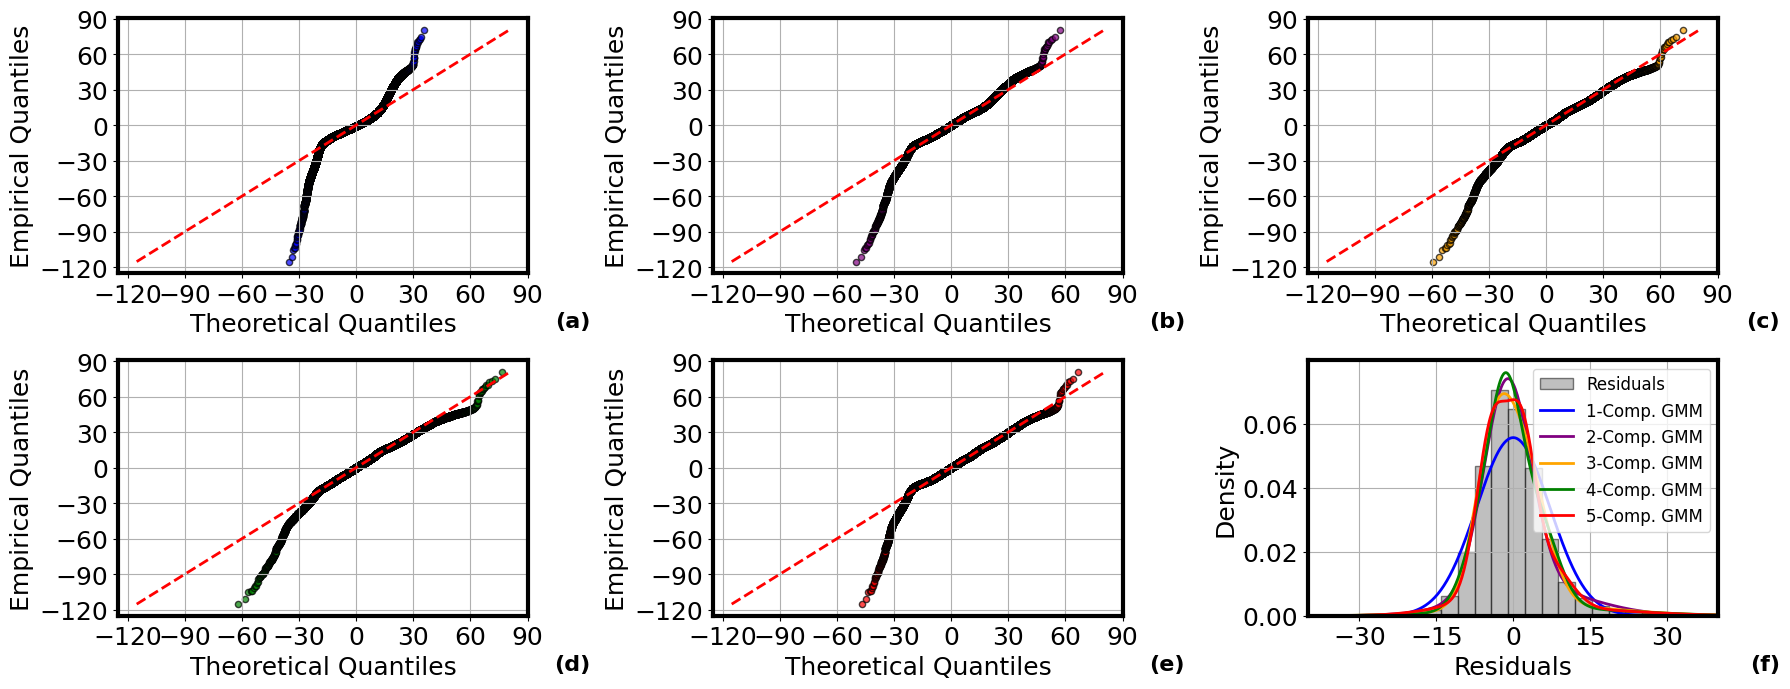

In [5]:
# --- Re-fit GMM models for 1 to 5 components and store them in a list ---
gmm_models = []
for k in range(1, 6):
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)

# Prepare sorted residuals and the corresponding probability positions
sorted_residuals = np.sort(residuals)
n = len(sorted_residuals)
probs = (np.arange(1, n + 1) - 0.5) / n  # Probability positions for quantiles

# --- Create a 2x3 grid for Q–Q plots and the combined histogram ---
fig, axes = plt.subplots(2, 3, figsize=(18, 7))
axes = axes.flatten()
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
gmm_colors = ['blue', 'purple', 'orange', 'green', 'red']

# --- Plot Q–Q plots for each of the 5 GMM models ---
for i, gmm_model in enumerate(gmm_models):
    ax = axes[i]
    
    # Generate a dense grid to compute the GMM CDF
    x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
    cdf_grid = gmm_cdf(x_grid, gmm_model)
    
    # Remove duplicate CDF values for reliable interpolation
    unique_cdf, unique_idx = np.unique(cdf_grid, return_index=True)
    unique_x = x_grid[unique_idx]
    # Create an interpolation function (PPF) from CDF to quantiles
    ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
    theoretical_quantiles = ppf_func(probs)
    
    # Scatter the theoretical versus empirical quantiles
    ax.scatter(theoretical_quantiles, sorted_residuals, color=gmm_colors[i], alpha=0.7, edgecolors='k', s=20)
    # Plot a 45° reference line
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    ax.set_xlabel('Theoretical Quantiles', fontsize=18)
    ax.set_ylabel('Empirical Quantiles', fontsize=18)
    #ax.set_title(f'GMM with {i+1} Component(s)', fontsize=20)
    ax.text(1.15, -0.15, subplot_labels[i], transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)
    ax.grid(True)

# --- Plot the 6th subplot: Histogram of residuals with overlaid GMM densities ---
ax6 = axes[5]
ax6.hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
for i, gmm_model in enumerate(gmm_models):
    # Compute the density for the current GMM (exponentiate the log probabilities)
    density = np.exp(gmm_model.score_samples(x_vals.reshape(-1, 1)))
    ax6.plot(x_vals, density, color=gmm_colors[i], linewidth=2, label=f'{i+1}-Comp. GMM')
    
ax6.set_xlabel('Residuals', fontsize=18)
ax6.set_ylabel('Density', fontsize=18)
ax6.legend(fontsize=12)
ax6.set_xlim(-40, 40)
ax6.grid(True)
ax6.text(1.15, -0.15, subplot_labels[5], transform=ax6.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)

# Set tick intervals and font sizes
for i, ax in enumerate(axes):
    if i < 5:  # Subplots (a) to (e)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.yaxis.set_major_locator(MultipleLocator(30))
    elif i == 5:  # Subplot (f)
        ax.xaxis.set_major_locator(MultipleLocator(15))
    
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(3)
        
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/gmm_qq_residual_plots.png', dpi=1000)
plt.show()

#### Print Distribution Parameters

In [6]:
# --- Print Distribution Parameters Including Best GMM ---

def print_group(title, params):
    bold_title = f"\033[1m=== {title} ===\033[0m"
    print(bold_title)
    for name, val in params:
        print(f"{name}: {val:.4f}")
    print("-" * 50)

# Normal Distribution
print_group("Normal Distribution", [("Mean (μ)", loc_norm), ("Std (σ)", scale_norm)])

# Skew-Normal Distribution
print_group("Skew-Normal Distribution", [("Shape", shape_sn), ("Location", loc_sn), ("Scale", scale_sn)])

# Gaussian Mixture Model (Using Best GMM from Diagnostics)
bold_title = f"\033[1m=== Gaussian Mixture Model (Best GMM) ===\033[0m"
print(bold_title)
for i in range(best_gmm.n_components):
    print(f"Component {i+1}:")
    print(f"  Weight (π): {best_gmm.weights_[i]:.4f}")
    if best_gmm.covariances_.ndim == 3:
        std = np.sqrt(best_gmm.covariances_[i][0][0])
    else:
        std = np.sqrt(best_gmm.covariances_[i])
    mean = best_gmm.means_[i][0]
    print(f"  Mean (μ):   {mean:.4f}")
    print(f"  Std (σ):    {std:.4f}")
print("-" * 50)

# Cauchy Distribution
print_group("Cauchy Distribution", [("Location", cauchy_params[0]), ("Scale", cauchy_params[1])])

# t-Distribution
print_group("t-Distribution", [("Degrees of Freedom (df)", df_t), ("Location", loc_t), ("Scale", scale_t)])

=== Normal Distribution ===
Mean (μ): 0.0000
Std (σ): 7.1705
--------------------------------------------------
=== Skew-Normal Distribution ===
Shape: 1.5531
Location: -6.2628
Scale: 9.5204
--------------------------------------------------
=== Gaussian Mixture Model (Best GMM) ===
Component 1:
  Weight (π): 0.4214
  Mean (μ):   2.4976
  Std (σ):    4.1665
Component 2:
  Weight (π): 0.4645
  Mean (μ):   -3.7510
  Std (σ):    3.7710
Component 3:
  Weight (π): 0.1142
  Mean (μ):   6.0429
  Std (σ):    14.5490
--------------------------------------------------
=== Cauchy Distribution ===
Location: -0.8231
Scale: 3.5021
--------------------------------------------------
=== t-Distribution ===
Degrees of Freedom (df): 3.7632
Location: -0.5691
Scale: 4.9261
--------------------------------------------------


#### Diagnostic Subplots 2×3 (Normal, Skew, best GMM, Cauchy, t, Histogram)

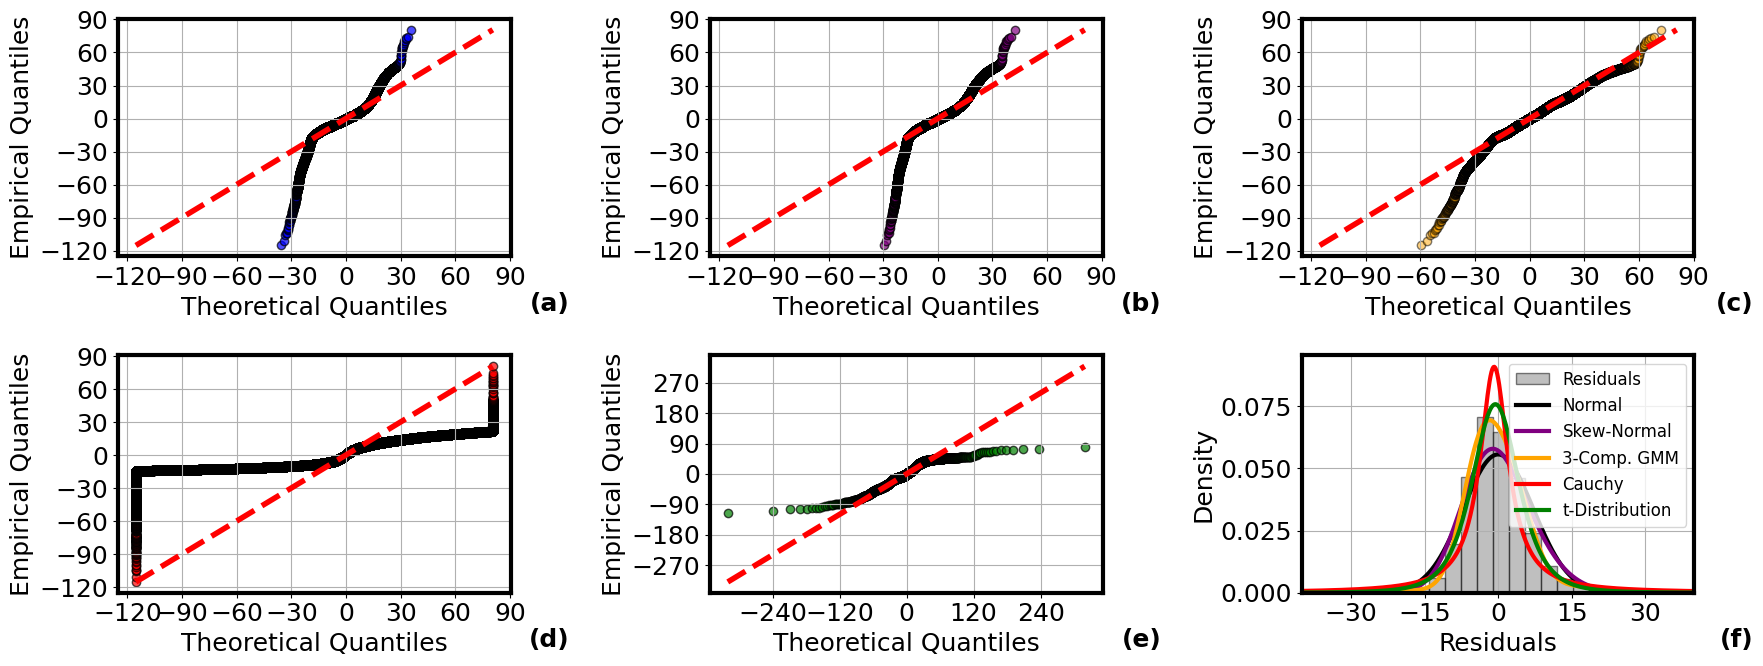

In [7]:
# === Plot Diagnostic Subplots in a 2x3 Grid ===
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'legend.fontsize': 15
})

fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Define subplot labels for the six subplots
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Function to create manual Q-Q plots
def manual_qq_plot(distribution, dist_name, sorted_residuals, probabilities, ax, color='blue'):
    """
    Create a manual Q-Q plot.
    """
    theoretical_quantiles = distribution.ppf(probabilities)
    ax.scatter(theoretical_quantiles, sorted_residuals, edgecolors='k', facecolor=color, alpha=0.7)
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
    #ax.set_title(f'{dist_name} Distribution')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Empirical Quantiles')
    ax.grid(True)

# 1. Q-Q Plot (Normal Distribution)
manual_qq_plot(normal_dist, 'Normal', sorted_residuals, probabilities, axes[0], color='blue')
axes[0].text(1.15, -0.15, subplot_labels[0], transform=axes[0].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 2. Q-Q Plot (Skew-Normal Distribution)
manual_qq_plot(skew_dist, 'Skew-Normal', sorted_residuals, probabilities, axes[1], color='purple')
axes[1].text(1.15, -0.15, subplot_labels[1], transform=axes[1].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 3. Q-Q Plot (Gaussian Mixture Model)
x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
cdf_grid = gmm_cdf(x_grid, best_gmm)  # Using best_gmm here
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]
ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
theoretical_gmm_quantiles = ppf_func(probabilities)

axes[2].scatter(theoretical_gmm_quantiles, sorted_residuals, edgecolors='k', facecolor='orange', alpha=0.5)
min_val = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
max_val = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
#axes[2].set_title('GMM Distribution')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Empirical Quantiles')
axes[2].grid(True)
axes[2].text(1.15, -0.15, subplot_labels[2], transform=axes[2].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 4. Q-Q Plot (Cauchy Distribution)
lower_bound = residuals.min()
upper_bound = residuals.max()
theoretical_quantiles = cauchy_dist.ppf(probabilities)
theoretical_quantiles_clipped = np.clip(theoretical_quantiles, lower_bound, upper_bound)

axes[3].scatter(theoretical_quantiles_clipped, sorted_residuals, edgecolors='k', facecolor='red', alpha=0.7)
axes[3].plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'r--', linewidth=4)
#axes[3].set_title('Cauchy Distribution')
axes[3].set_xlabel('Theoretical Quantiles')
axes[3].set_ylabel('Empirical Quantiles')
axes[3].grid(True)
axes[3].text(1.15, -0.15, subplot_labels[3], transform=axes[3].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 5. Q-Q Plot (t-Distribution)
manual_qq_plot(t_dist, 't-', sorted_residuals, probabilities, axes[4], color='green')
axes[4].text(1.15, -0.15, subplot_labels[4], transform=axes[4].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 6. Residuals Histogram with Fitted Densities
axes[5].hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[5].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='black', linewidth=3)
axes[5].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=3)
# Using best_gmm to compute density
gmm_density = np.exp(best_gmm.score_samples(x_vals.reshape(-1, 1)))
axes[5].plot(x_vals, gmm_density, label=f'{best_gmm.n_components}-Comp. GMM', color='orange', linewidth=3)
axes[5].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=3)
axes[5].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='green', linewidth=3)
#axes[5].set_title('Residuals Distributions')
axes[5].set_xlabel('Residuals')
axes[5].set_ylabel('Density')
axes[5].legend(fontsize=12)
axes[5].grid(True)
axes[5].set_xlim(-40, 40)
axes[5].text(1.15, -0.15, subplot_labels[5], transform=axes[5].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# ----- Tick Interval Adjustments  -----
# For subplots a-d (axes[0] to axes[3]), 30
for i in range(0, 4):
    axes[i].xaxis.set_major_locator(MultipleLocator(30))
    axes[i].yaxis.set_major_locator(MultipleLocator(30))

# For subplot e (axes[4]), 60
axes[4].xaxis.set_major_locator(MultipleLocator(120))
axes[4].yaxis.set_major_locator(MultipleLocator(90))

# For histogram subplot f (axes[5]), 15
axes[5].xaxis.set_major_locator(MultipleLocator(15))
# ----- End of Tick Interval Adjustments -----

# Adjust tick font size for all subplots
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=18)

# Set all subplot border widths (spines) to 3 
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(3)

# Adjust layout, save figure, and display
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/qq_residual_plots.png', dpi=1000)
plt.show()

In [8]:
# ========================== SPEED HEADER (single-BLAS + joblib CV) ==========================
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Parallelism knob (Ryzen 7950X: 16–24 typical; tune to your box)
N_JOBS = 18


# ============================== Utilities & options ===============================
import warnings, math
from typing import Optional, Sequence, Tuple, Iterable, List
from dataclasses import dataclass
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from threadpoolctl import threadpool_limits
from joblib import Parallel, delayed

from scipy.signal import find_peaks
from scipy.stats import norm as stdnorm
from scipy.optimize import brentq
import statsmodels.api as sm

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

warnings.filterwarnings("ignore")
rng = np.random.default_rng(42)

# small helper to seed joblib workers deterministically
def _seeds(base_seed: int, n: int) -> np.ndarray:
    return np.random.default_rng(base_seed).integers(0, 2**32 - 1, size=n, dtype=np.uint32)

# progress bars
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k): return x

In [9]:
# --- helpers to find optional columns in df_res ---
def find_col(df: pd.DataFrame, candidates: Sequence[str]) -> Optional[str]:
    for c in candidates:
        if c in df.columns:
            return c
        for col in df.columns:
            if col.lower() == c.lower():
                return col
    return None

col_fold   = find_col(df_res, ["fold", "cv_fold", "group"])
col_dev    = find_col(df_res, ["device", "ed", "ED", "node"])
col_los    = find_col(df_res, ["los", "is_los", "LoS"])
col_fitted = find_col(df_res, ["fitted", "yhat", "y_pred", "pred"])
col_co2    = find_col(df_res, ["co2", "co2_ppm", "CO2"])

print("Optional columns detected ->",
      f"fold={col_fold}, device={col_dev}, los={col_los}, fitted={col_fitted}, co2={col_co2}")

# numpy views
x_res = residuals.values.astype(float).reshape(-1, 1)
x_res_1d = residuals.values.astype(float)
n = x_res.shape[0]

# sensible grids
XMIN, XMAX = float(x_res_1d.min()), float(x_res_1d.max())
grid_pdf = np.linspace(XMIN, XMAX, 4096)
grid_cdf = np.linspace(XMIN, XMAX, 200_000)

Optional columns detected -> fold=fold, device=None, los=None, fitted=None, co2=co2


[LSCV] bandwidth (approx, memory-safe) = 0.21021
Silverman h = 0.29728 ; Selected h (LSCV/LL-CV) = 0.21021


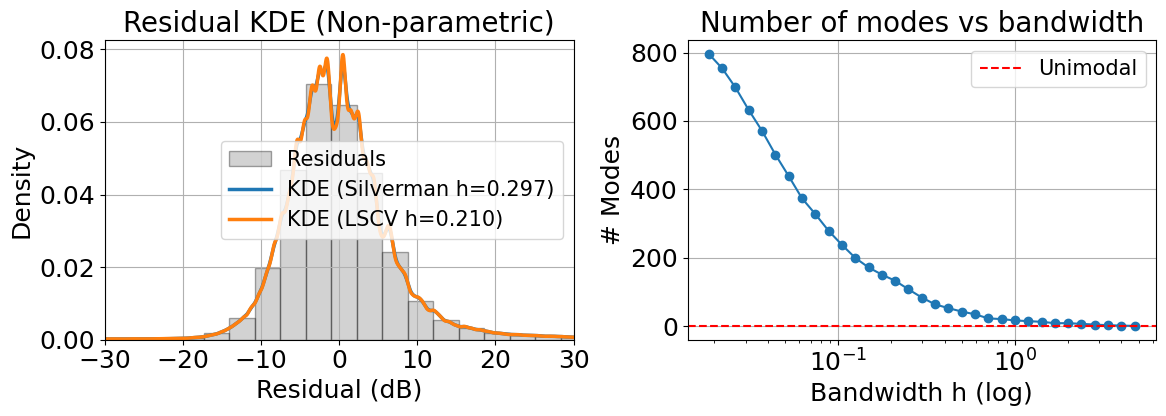

In [10]:
# ============================== KDE & modality scans (MEMORY-SAFE) ==============================

def silverman_bw(x: np.ndarray) -> float:
    x = np.asarray(x).ravel()
    sigma = np.std(x, ddof=1)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    s = min(sigma, iqr / 1.349) if np.isfinite(iqr) and iqr > 0 else sigma
    return 0.9 * s * (x.size ** (-1/5))

# ---- memory-safe LSCV (approximate) with parallel per-h ----
def lscv_bandwidth_safe(
    x: np.ndarray,
    hs: np.ndarray,
    rng=np.random.default_rng(42),
    m_x: int = 4000,
    m_y: int = 4000,
    chunk_y: int = 2000,
    max_mb_per_chunk: int = 256,
    n_jobs: int = N_JOBS,
):
    x = np.asarray(x).ravel().astype(np.float32)
    n = x.size
    m_x = min(m_x, n)
    m_y = min(m_y, n)

    # independent subsamples
    idx_x = rng.choice(n, size=m_x, replace=False)
    idx_y = rng.choice(n, size=m_y, replace=False)
    xi = x[idx_x].astype(np.float32)
    yj = x[idx_y].astype(np.float32)

    # choose chunk size based on memory target
    if chunk_y * xi.size * 4 / (1024**2) > max_mb_per_chunk:
        chunk_y_eff = max(500, int(max_mb_per_chunk * (1024**2) / (xi.size * 4)))
    else:
        chunk_y_eff = chunk_y

    def mean_kde_vals(h: float) -> np.ndarray:
        inv_h = np.float32(1.0 / h)
        out = np.zeros_like(xi, dtype=np.float64)
        count = 0
        for start in range(0, yj.size, chunk_y_eff):
            end = min(start + chunk_y_eff, yj.size)
            y_blk = yj[start:end].reshape(1, -1)          # (1,B)
            xi_col = xi.reshape(-1, 1)                    # (m_x,1)
            z = (xi_col - y_blk) * inv_h                  # (m_x,B), float32
            K = np.exp(-0.5 * (z**2)).astype(np.float32) * inv_h
            out += K.mean(axis=1)
            count += 1
        return out / max(count, 1)

    def int_f_sq(h: float) -> float:
        coef = 1.0 / (np.sqrt(4.0 * np.pi) * h)
        denom = 4.0 * (h**2)
        B = 2000
        accum = 0.0
        pairs = 0
        for i_start in range(0, xi.size, B):
            i_end = min(i_start + B, xi.size)
            xi_blk = xi[i_start:i_end].reshape(-1, 1)
            for j_start in range(0, xi.size, B):
                j_end = min(j_start + B, xi.size)
                xj_blk = xi[j_start:j_end].reshape(1, -1)
                d2 = (xi_blk - xj_blk)**2
                accum += np.exp(-(d2 / denom)).sum()
                pairs += d2.size
        return float(coef * (accum / pairs))

    def score_one(i_h: int, h: float) -> Tuple[int, float]:
        if not np.isfinite(h) or h <= 0:
            return i_h, np.inf
        # to avoid nested BLAS threads inside workers
        with threadpool_limits(1):
            mvals = mean_kde_vals(h)
            term2 = 2.0 * float(mvals.mean())
            term1 = float(int_f_sq(h))
            return i_h, (term1 - term2)

    hs = np.asarray(hs, dtype=float)
    results = Parallel(n_jobs=n_jobs, prefer="threads", batch_size="auto")(
        delayed(score_one)(i, h) for i, h in enumerate(hs)
    )
    scores = [np.inf] * len(hs)
    for i, sc in results:
        scores[i] = sc
    return float(hs[int(np.nanargmin(scores))])

# ----- RUN: bandwidth selection -----
x = x_res_1d
h_silv = silverman_bw(x)
hs = h_silv * (2.0 ** np.linspace(-3, +3, 25))

try:
    h_lscv = lscv_bandwidth_safe(x, hs, m_x=4000, m_y=4000, chunk_y=2000,
                                 max_mb_per_chunk=256, n_jobs=N_JOBS)
    print(f"[LSCV] bandwidth (approx, memory-safe) = {h_lscv:.5f}")
except Exception as e:
    from sklearn.model_selection import KFold
    print(f"[LSCV] fallback due to: {e}")
    n_sub = min(100_000, x.size)
    sub = rng.choice(x.size, size=n_sub, replace=False)
    xs = x[sub].reshape(-1,1)
    cand = h_silv * (2.0 ** np.linspace(-2, +2, 13))
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    def ll_for_h(h):
        with threadpool_limits(1):
            ll = 0.0
            for tr, va in kf.split(xs):
                kde = KernelDensity(kernel="gaussian", bandwidth=h).fit(xs[tr])
                ll += kde.score(xs[va])
            return h, ll

    h_ll = Parallel(n_jobs=N_JOBS, prefer="threads")(
        delayed(ll_for_h)(h) for h in cand
    )
    best_ll, h_lscv = max((ll, h) for h, ll in h_ll)
    print(f"[CV-LL] bandwidth (fallback) = {h_lscv:.5f}")

# ---- final KDEs on a common grid ----
kde_silv = KernelDensity(kernel="gaussian", bandwidth=h_silv).fit(x_res)
kde_lscv = KernelDensity(kernel="gaussian", bandwidth=h_lscv).fit(x_res)
dens_silv = np.exp(kde_silv.score_samples(grid_pdf.reshape(-1, 1)))
dens_lscv = np.exp(kde_lscv.score_samples(grid_pdf.reshape(-1, 1)))
print(f"Silverman h = {h_silv:.5f} ; Selected h (LSCV/LL-CV) = {h_lscv:.5f}")

def count_modes_from_kde(kde_model, grid=grid_pdf, prominence=1e-5):
    y = np.exp(kde_model.score_samples(grid.reshape(-1,1)))
    peaks, _ = find_peaks(y)
    return len(peaks), y

# ---- parallel modes vs bandwidth scan ----
hs_scan = h_silv * (2.0 ** np.linspace(-4, +4, 33))

def modes_at_h(h: float) -> Tuple[float, int]:
    with threadpool_limits(1):
        km = KernelDensity(kernel="gaussian", bandwidth=h).fit(x_res)
        m,_ = count_modes_from_kde(km)
        return h, m

modes_scan = Parallel(n_jobs=N_JOBS, prefer="threads")(delayed(modes_at_h)(h) for h in hs_scan)

# --- Plots: KDE & modes scan ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
axes[0].hist(x_res_1d, bins=60, density=True, alpha=0.35, color='grey', edgecolor='black', label='Residuals')
axes[0].plot(grid_pdf, dens_silv, lw=2.5, label=f'KDE (Silverman h={h_silv:.3f})')
axes[0].plot(grid_pdf, dens_lscv, lw=2.5, label=f'KDE (LSCV h={h_lscv:.3f})')
axes[0].set(xlim=(-30, 30))
axes[0].set_title('Residual KDE (Non-parametric)')
axes[0].set_xlabel('Residual (dB)'); axes[0].set_ylabel('Density'); axes[0].grid(True); axes[0].legend()

axes[1].plot([h for h,_ in modes_scan], [m for _,m in modes_scan], marker='o')
axes[1].axhline(1, color='r', ls='--', lw=1.5, label='Unimodal')
axes[1].set_xscale('log')
axes[1].set_title('Number of modes vs bandwidth')
axes[1].set_xlabel('Bandwidth h (log)'); axes[1].set_ylabel('# Modes'); axes[1].grid(True); axes[1].legend()
plt.tight_layout(); plt.show()

In [ ]:
# ============================== Modality tests (parallel Silverman) ==============================
from diptest import diptest

def dip_test_safe(x: np.ndarray, B: int = 1000):
    x = np.asarray(x).ravel()
    d, p = diptest(x)
    return float(d), float(p), "diptest"

def critical_bandwidth_silverman(x: np.ndarray,
                                 h_grid: Optional[np.ndarray] = None,
                                 alpha_modes: int = 1,
                                 B: int = 399,
                                 n_jobs: int = N_JOBS) -> Tuple[float, float]:
    """
    Returns (h_crit, p_value) where h_crit is the smallest bandwidth giving <= alpha_modes modes.
    p-value via smoothed bootstrap (Silverman 1981). Bootstrap is parallelized across replicates.
    """
    x = np.asarray(x).ravel()
    n = x.size

    h0 = silverman_bw(x)
    if h_grid is None:
        h_grid = np.sort(h0 * (2.0 ** np.linspace(-4, +4, 41)))

    def modes_for_h(h, arr) -> int:
        km = KernelDensity(kernel="gaussian", bandwidth=h).fit(arr[:, None])
        m,_ = count_modes_from_kde(km)  # uses global grid_pdf
        return m

    # observed hcrit
    hcrit = float(h_grid[-1])
    for h in h_grid:
        if modes_for_h(h, x) <= alpha_modes:
            hcrit = float(h); break

    # parallel smoothed bootstrap replicates
    seeds = _seeds(42, B)

    def one_boot(seed: int) -> float:
        with threadpool_limits(1):
            rng_local = np.random.default_rng(int(seed))
            xb = x[rng_local.integers(0, n, n)] + hcrit * rng_local.standard_normal(n)
            hcrit_b = float(h_grid[-1])
            for h in h_grid:
                if modes_for_h(h, xb) <= alpha_modes:
                    hcrit_b = float(h); break
            return hcrit_b

    h_b_list: List[float] = Parallel(n_jobs=n_jobs, prefer="threads")(delayed(one_boot)(s) for s in seeds)
    count = sum(hb <= hcrit for hb in h_b_list)
    pval = (count + 1) / (B + 1)
    return hcrit, pval

# ---- RUN + PRINTS ----
dip_val, dip_p, dip_src = dip_test_safe(x_res_1d)
print(f"Hartigan Dip: dip={dip_val:.6f}, p={dip_p:.4f} (src={dip_src})")

hcrit, p_silv = critical_bandwidth_silverman(x_res_1d, alpha_modes=1, B=199, n_jobs=N_JOBS)
print(f"Silverman critical bandwidth: h*={hcrit:.4f}, p={p_silv:.4f} (unimodality null)")

Hartigan Dip: dip=0.004243, p=0.0000 (src=diptest)
